In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

import numpy as np

from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)

from src.utils.constants import GenParamTuple# candidate_environments_args["n_environments"] = 50


np.set_printoptions(linewidth=160, precision=2)

from src.utils.environment_design import EnvironmentDesign

## Make true environment

In [8]:
# 0. Setup
N, M = 7, 7



# Start by making the agent we want to learn the parameters of
agent_gamma = np.array(0.8)
p_true= np.array(0.95)
big_reward_true = np.array([0.9, 0.6])

agent_R = np.zeros((N, M))
agent_R[N-1, 0] = big_reward_true[0]
agent_R[0, M-1] = big_reward_true[1]
# agent_R[N-1, M-1] = big_reward_true[2]
agent_R = agent_R.flatten()

goal_states = np.where(agent_R != 0)[0]

wall_states = []
wall_states.append(1*N+2)
wall_states.append(1*N+3)
wall_states.append(3*N+1)
wall_states.append(3*N+2)
wall_states.append(4*N+5)
wall_states.append(4*N+6)


T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)


#Define custom functions to generate reward, transition and gamma.
def custom_transition_func(p):

    _T = transition_matrix(N=N, M=M, p=p, absorbing_states=goal_states)
    _T = insert_walls_into_T(T=_T, wall_indices=wall_states)
    return _T

def custom_gamma_func(gamma):
    return gamma

def custom_reward_func(big_reward_1, big_reward_2):
    reward_func = np.zeros((N, M))
    reward_func[N-1, 0] = big_reward_1
    reward_func[0,M-1] = big_reward_2
    # reward_func[N-1, M-1] = big_reward_3
    return reward_func.flatten()


#Create parameter ranges
resolution = 20
p_range = np.linspace(0.7, 0.95, resolution)
gamma_range = np.linspace(0.7, 0.95, resolution)
R_range_1 = np.linspace(0.3, 0.95, resolution)
R_range_2 = np.linspace(0.3, 0.95, resolution)
# R_range_3 = np.linspace(0.3, 0.95, resolution)
R_range = np.array([R_range_1, R_range_2])

gamma_range = gamma_range.reshape(1, resolution)
p_range = p_range.reshape(1, resolution)
R_range = R_range.reshape(len(R_range), resolution)

p_true = p_true.reshape(1, 1)
agent_gamma = agent_gamma.reshape(1, 1)
big_reward_true = big_reward_true.reshape(len(R_range), 1)



true_params = GenParamTuple(T = p_true, gamma=agent_gamma, R=big_reward_true)




maze = Environment(
    N=N,
    M=M,
    reward_function = custom_reward_func,
    transition_function=custom_transition_func,
    gamma = custom_gamma_func,
    wall_states=wall_states,
    start_state=0,
    goal_states=goal_states
)

In [32]:
def run_all_methods(true_params, n_runs=5):

    method_names = ["BIRL", "ED-BIRL", "AMBER_random", "AMBER"]

    for method_name in method_names:

        print("\n\n\n" + method_name + "\n\n\n")

        if method_name == "BIRL":

            candidate_environments_args = {}
            candidate_environments_args["generate_how"] = "BIRL"

        elif method_name == "ED-BIRL":

            candidate_environments_args = {}
            candidate_environments_args["generate_how"] = "ED-BIRL"
            candidate_environments_args["n_environments"] = 150
            candidate_environments_args["n_walls"] = 5
            candidate_environments_args["how"] = "value"

        elif method_name == "AMBER_random":

            candidate_environments_args = {}
            candidate_environments_args["generate_how"] = "AMBER_random"
            candidate_environments_args["n_compute_BM"] = 3
            candidate_environments_args["n_iterations"] = 1
            candidate_environments_args["stepsize"] = 0.0001

        elif method_name == "AMBER":

            candidate_environments_args = {}
            candidate_environments_args["generate_how"] = "AMBER"
            candidate_environments_args["n_compute_BM"] = 100
            candidate_environments_args["n_iterations"] = 1
            candidate_environments_args["stepsize"] = 0.0001

        for idx_run in range(n_runs):

            print("\n\n\n Run " + str(idx_run+1) + "/" + str(n_runs) + "\n\n\n")

            env_design = EnvironmentDesign(base_environment=maze, 
                                           user_params=true_params, 
                                           learn_what = ["R"],
                                           parameter_ranges_R=R_range,
                                           parameter_ranges_gamma=gamma_range,
                                           parameter_ranges_T=p_range)

            env_design.run_n_episodes(n_episodes = 15,
                        candidate_environments_args=candidate_environments_args,
                        verbose=True)

            env_design.save(f"maze/Rtrue={str(big_reward_true.tolist())}/" + candidate_environments_args["generate_how"])

In [33]:
run_all_methods(true_params, n_runs=5)




BIRL






 Run 0/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.


/tmp/ipykernel_4765/3750675007.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward_func[N-1, 0] = big_reward_1
/tmp/ipykernel_4765/3750675007.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward_func[0,M-1] = big_reward_2


Mean Parameters: [0.6853940117095438, 0.5686945656733068]
Computed Region of Interest. Size = 0.6
Started episode 2.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7272075390857191, 0.5332899178112759]
Computed Region of Interest. Size = 0.46
Started episode 3.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7550892134650661, 0.5083851932177827]
Computed Region of Interest. Size = 0.37
Started episode 4.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.780854995421815, 0.4883441264290075]
Computed Region of Interest. Size = 0.29
Started episode 5.
Starting conventional Bayesian IRL.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8151046333165033, 0.487035644579991]
Computed Region of Interest. Size = 0.24
Started episode 6.
Start

Evaluating candidate environments using value: 100%|██████████| 250/250 [01:24<00:00,  2.97it/s, highest_regret=0.974]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6559721146227689, 0.6036429706347397]
Computed Region of Interest. Size = 0.62
Started episode 2.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:12<00:00,  3.43it/s, highest_regret=0.482]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6846606716512558, 0.5843563105943927]
Computed Region of Interest. Size = 0.46
Started episode 3.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:23<00:00,  2.99it/s, highest_regret=0.715]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6996454572666815, 0.5891900140202678]
Computed Region of Interest. Size = 0.35
Started episode 4.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:22<00:00,  3.03it/s, highest_regret=0.671]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7092653140355586, 0.5832882227975289]
Computed Region of Interest. Size = 0.28
Started episode 5.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:12<00:00,  3.43it/s, highest_regret=0.375]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.723893641702892, 0.5897795606082851]
Computed Region of Interest. Size = 0.22
Started episode 6.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:27<00:00,  2.86it/s, highest_regret=0.713]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7635753922287283, 0.6289705173644885]
Computed Region of Interest. Size = 0.18
Started episode 7.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:46<00:00,  2.35it/s, highest_regret=1.21]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7756191380146459, 0.6271343112636506]
Computed Region of Interest. Size = 0.14
Started episode 8.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:20<00:00,  3.12it/s, highest_regret=0.426]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8040964791523603, 0.6598387785260545]
Computed Region of Interest. Size = 0.12
Started episode 9.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:35<00:00,  2.61it/s, highest_regret=0.834]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.826110733166966, 0.6698486775082791]
Computed Region of Interest. Size = 0.09
Started episode 10.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:37<00:00,  2.57it/s, highest_regret=0.909]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8383721596993245, 0.6765404927727711]
Computed Region of Interest. Size = 0.07
Started episode 11.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:30<00:00,  2.77it/s, highest_regret=0.502]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8555090073912381, 0.6969429063543405]
Computed Region of Interest. Size = 0.06
Started episode 12.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:26<00:00,  2.88it/s, highest_regret=0.637]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8745371409725352, 0.7119908784219621]
Computed Region of Interest. Size = 0.05
Started episode 13.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:28<00:00,  2.81it/s, highest_regret=0.648]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8765367195569127, 0.7071701161003995]
Computed Region of Interest. Size = 0.04
Started episode 14.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:28<00:00,  2.82it/s, highest_regret=0.698]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.892320120130902, 0.7148589221639182]
Computed Region of Interest. Size = 0.03
saved in filepath /home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/checkpoints/maze/Rtrue=[[0.8], [0.6]]/ED-BIRL/26.05.2024



 Run 1/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:27<00:00,  2.86it/s, highest_regret=0.48] 


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6853940117095438, 0.5686945656733068]
Computed Region of Interest. Size = 0.6
Started episode 2.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:30<00:00,  2.76it/s, highest_regret=0.674]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7272075390857191, 0.5332899178112759]
Computed Region of Interest. Size = 0.46
Started episode 3.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:33<00:00,  2.68it/s, highest_regret=0.434]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7550892134650661, 0.5083851932177827]
Computed Region of Interest. Size = 0.37
Started episode 4.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:21<00:00,  3.09it/s, highest_regret=0.428]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.780854995421815, 0.4883441264290075]
Computed Region of Interest. Size = 0.29
Started episode 5.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:43<00:00,  2.41it/s, highest_regret=0.856]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8151046333165033, 0.487035644579991]
Computed Region of Interest. Size = 0.24
Started episode 6.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:16<00:00,  3.29it/s, highest_regret=0.52]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8496081660281677, 0.49840553532809273]
Computed Region of Interest. Size = 0.19
Started episode 7.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:15<00:00,  3.31it/s, highest_regret=0.543]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8694724222555463, 0.4926629881756161]
Computed Region of Interest. Size = 0.15
Started episode 8.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:17<00:00,  3.21it/s, highest_regret=0.619]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.890013980075364, 0.49796615892315993]
Computed Region of Interest. Size = 0.12
Started episode 9.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:13<00:00,  3.38it/s, highest_regret=0.543]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9032361930432941, 0.4954854812772501]
Computed Region of Interest. Size = 0.1
Started episode 10.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:23<00:00,  2.99it/s, highest_regret=0.858]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9149427753609232, 0.5009806839693753]
Computed Region of Interest. Size = 0.08
Started episode 11.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:30<00:00,  2.75it/s, highest_regret=0.954]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9222099223962589, 0.4764020338594117]
Computed Region of Interest. Size = 0.07
Started episode 12.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:40<00:00,  2.49it/s, highest_regret=1.11]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9315821446370403, 0.49736405873609363]
Computed Region of Interest. Size = 0.05
Started episode 13.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:20<00:00,  3.09it/s, highest_regret=0.668]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9369694421420762, 0.47268315828627533]
Computed Region of Interest. Size = 0.04
Started episode 14.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:05<00:00,  3.81it/s, highest_regret=0.237]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9419520061470883, 0.48513872170717587]
Computed Region of Interest. Size = 0.04
saved in filepath /home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/checkpoints/maze/Rtrue=[[0.8], [0.6]]/ED-BIRL/26.05.2024



 Run 2/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:23<00:00,  3.00it/s, highest_regret=0.62]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6853940117095438, 0.5686945656733068]
Computed Region of Interest. Size = 0.6
Started episode 2.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:28<00:00,  2.84it/s, highest_regret=0.8]  


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7272075390857191, 0.5332899178112759]
Computed Region of Interest. Size = 0.46
Started episode 3.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:29<00:00,  2.80it/s, highest_regret=0.661]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7550892134650661, 0.5083851932177827]
Computed Region of Interest. Size = 0.37
Started episode 4.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:08<00:00,  3.64it/s, highest_regret=0.577]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.780854995421815, 0.4883441264290075]
Computed Region of Interest. Size = 0.29
Started episode 5.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:18<00:00,  3.20it/s, highest_regret=0.836]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8151046333165033, 0.487035644579991]
Computed Region of Interest. Size = 0.24
Started episode 6.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:25<00:00,  2.92it/s, highest_regret=0.718]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8496081660281677, 0.49840553532809273]
Computed Region of Interest. Size = 0.19
Started episode 7.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:29<00:00,  2.79it/s, highest_regret=0.976]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8694724222555463, 0.4926629881756161]
Computed Region of Interest. Size = 0.15
Started episode 8.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:21<00:00,  3.05it/s, highest_regret=0.942]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.890013980075364, 0.49796615892315993]
Computed Region of Interest. Size = 0.12
Started episode 9.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:33<00:00,  2.67it/s, highest_regret=1.4]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9032361930432941, 0.4954854812772501]
Computed Region of Interest. Size = 0.1
Started episode 10.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:12<00:00,  3.44it/s, highest_regret=0.588]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9149427753609232, 0.5009806839693753]
Computed Region of Interest. Size = 0.08
Started episode 11.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s, highest_regret=0.26] 


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9222099223962589, 0.4764020338594117]
Computed Region of Interest. Size = 0.07
Started episode 12.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:00<00:00,  4.11it/s, highest_regret=0.276]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9315821446370403, 0.49736405873609363]
Computed Region of Interest. Size = 0.05
Started episode 13.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:02<00:00,  3.99it/s, highest_regret=0.278]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9369694421420762, 0.47268315828627533]
Computed Region of Interest. Size = 0.04
Started episode 14.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:18<00:00,  3.18it/s, highest_regret=0.62]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9419520061470883, 0.48513872170717587]
Computed Region of Interest. Size = 0.04
saved in filepath /home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/checkpoints/maze/Rtrue=[[0.8], [0.6]]/ED-BIRL/26.05.2024



 Run 3/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:04<00:00,  3.87it/s, highest_regret=0.203]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6853940117095438, 0.5686945656733068]
Computed Region of Interest. Size = 0.6
Started episode 2.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:08<00:00,  3.66it/s, highest_regret=0.325]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7272075390857191, 0.5332899178112759]
Computed Region of Interest. Size = 0.46
Started episode 3.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:16<00:00,  3.29it/s, highest_regret=0.435]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7550892134650661, 0.5083851932177827]
Computed Region of Interest. Size = 0.37
Started episode 4.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:23<00:00,  2.99it/s, highest_regret=0.587]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.780854995421815, 0.4883441264290075]
Computed Region of Interest. Size = 0.29
Started episode 5.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:26<00:00,  2.88it/s, highest_regret=0.701]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8151046333165033, 0.487035644579991]
Computed Region of Interest. Size = 0.24
Started episode 6.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:33<00:00,  2.66it/s, highest_regret=1]    


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8496081660281677, 0.49840553532809273]
Computed Region of Interest. Size = 0.19
Started episode 7.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:12<00:00,  3.45it/s, highest_regret=0.447]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8694724222555463, 0.4926629881756161]
Computed Region of Interest. Size = 0.15
Started episode 8.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:17<00:00,  3.23it/s, highest_regret=0.794]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.890013980075364, 0.49796615892315993]
Computed Region of Interest. Size = 0.12
Started episode 9.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:05<00:00,  3.83it/s, highest_regret=0.337]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9032361930432941, 0.4954854812772501]
Computed Region of Interest. Size = 0.1
Started episode 10.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:18<00:00,  3.18it/s, highest_regret=0.619]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9149427753609232, 0.5009806839693753]
Computed Region of Interest. Size = 0.08
Started episode 11.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:45<00:00,  2.36it/s, highest_regret=1.35]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9222099223962589, 0.4764020338594117]
Computed Region of Interest. Size = 0.07
Started episode 12.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:15<00:00,  3.30it/s, highest_regret=0.325]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9315821446370403, 0.49736405873609363]
Computed Region of Interest. Size = 0.05
Started episode 13.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:21<00:00,  3.07it/s, highest_regret=0.736]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9369694421420762, 0.47268315828627533]
Computed Region of Interest. Size = 0.04
Started episode 14.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:33<00:00,  2.67it/s, highest_regret=0.88] 


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9419520061470883, 0.48513872170717587]
Computed Region of Interest. Size = 0.04
saved in filepath /home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/checkpoints/maze/Rtrue=[[0.8], [0.6]]/ED-BIRL/26.05.2024



 Run 4/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:11<00:00,  3.49it/s, highest_regret=0.309]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6853940117095438, 0.5686945656733068]
Computed Region of Interest. Size = 0.6
Started episode 2.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:09<00:00,  3.60it/s, highest_regret=0.343]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7272075390857191, 0.5332899178112759]
Computed Region of Interest. Size = 0.46
Started episode 3.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:02<00:00,  3.97it/s, highest_regret=0.27]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.7550892134650661, 0.5083851932177827]
Computed Region of Interest. Size = 0.37
Started episode 4.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:17<00:00,  3.24it/s, highest_regret=0.573]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.780854995421815, 0.4883441264290075]
Computed Region of Interest. Size = 0.29
Started episode 5.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:26<00:00,  2.88it/s, highest_regret=0.656]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8151046333165033, 0.487035644579991]
Computed Region of Interest. Size = 0.24
Started episode 6.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:18<00:00,  3.18it/s, highest_regret=0.569]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8496081660281677, 0.49840553532809273]
Computed Region of Interest. Size = 0.19
Started episode 7.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:12<00:00,  3.45it/s, highest_regret=0.509]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.8694724222555463, 0.4926629881756161]
Computed Region of Interest. Size = 0.15
Started episode 8.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:12<00:00,  3.45it/s, highest_regret=0.514]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.890013980075364, 0.49796615892315993]
Computed Region of Interest. Size = 0.12
Started episode 9.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:20<00:00,  3.12it/s, highest_regret=0.655]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9032361930432941, 0.4954854812772501]
Computed Region of Interest. Size = 0.1
Started episode 10.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:26<00:00,  2.87it/s, highest_regret=0.83] 


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9149427753609232, 0.5009806839693753]
Computed Region of Interest. Size = 0.08
Started episode 11.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:16<00:00,  3.26it/s, highest_regret=0.571]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9222099223962589, 0.4764020338594117]
Computed Region of Interest. Size = 0.07
Started episode 12.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:24<00:00,  2.97it/s, highest_regret=0.898]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9315821446370403, 0.49736405873609363]
Computed Region of Interest. Size = 0.05
Started episode 13.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:33<00:00,  2.67it/s, highest_regret=0.857]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9369694421420762, 0.47268315828627533]
Computed Region of Interest. Size = 0.04
Started episode 14.


Evaluating candidate environments using value: 100%|██████████| 250/250 [01:21<00:00,  3.07it/s, highest_regret=0.765]


Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.9419520061470883, 0.48513872170717587]
Computed Region of Interest. Size = 0.04
saved in filepath /home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/checkpoints/maze/Rtrue=[[0.8], [0.6]]/ED-BIRL/26.05.2024



AMBER_random






 Run 0/5



Generated parameter mesh of shape:  (20, 20)
Started episode 0.
Finished episode 0.
Started episode 1.
Starting AMBER.
Beginning calculation of log-likelihood. Calculating 400 samples.
Mean Parameters: [0.6488929910932587, 0.5793447501666219]
Computed Region of Interest. Size = 0.59
Behavior Map: ExperimentResult(data=array([0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0,

In [4]:
candidate_environments_args = {}
candidate_environments_args["generate_how"] = "AMBER_random"
candidate_environments_args["n_compute_BM"] = 3
candidate_environments_args["n_iterations"] = 1
candidate_environments_args["stepsize"] = 0.0001

# for _ in range(2):
    # candidate_environments_args = {}
    # candidate_environments_args["generate_how"] = "BIRL"
    # candidate_environments_args["n_environments"] = 250
    # candidate_environments_args["n_walls"] = 5
    # candidate_environments_args["how"] = "value"


env_design.run_n_episodes(n_episodes = 15,
                        candidate_environments_args=candidate_environments_args,
                        verbose=True)
env_design.save(f"checkpoints/maze/" + candidate_environments_args["generate_how"])


Started episode 0.
Finished episode 0.
Started episode 1.
Starting AMBER.
Beginning calculation of log-likelihood. Calculating 400 samples.


/tmp/ipykernel_4765/878692065.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward_func[N-1, 0] = big_reward_1
/tmp/ipykernel_4765/878692065.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward_func[0,M-1] = big_reward_2


Mean Parameters: [0.6853940117095438, 0.5686945656733068]
Computed Region of Interest. Size = 0.6
Behavior Map: ExperimentResult(data=array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32), p2idx={'DDDDDD': 0, 'RRRRRR': 1}, pidx2states={0: [0, 7, 14, 21, 28, 35, 42], 1: [0, 1, 2, 3, 4, 5,

In [5]:
env_design.save(f"checkpoints/maze/" + candidate_environments_args["generate_how"])


saved in filepath /home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/checkpoints/checkpoints/maze/AMBER_random/26.05.2024


In [6]:
import pickle

with open("checkpoints/checkpoints/maze/ED-BIRL/24.05.2024/11:21:01", "rb") as file:
    res = pickle.load(file)


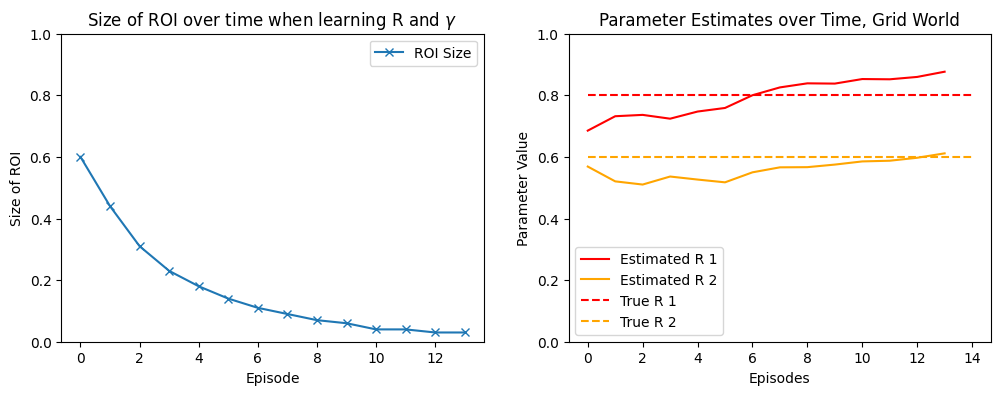

In [7]:
params = env_design.diagnostics["parameter_means"]
params = np.array(params)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

roi_sizes = env_design.diagnostics["ROI_sizes"]
roi_sizes = np.array(roi_sizes)
axs[0].plot(roi_sizes, "-x", label="ROI Size")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Size of ROI")
axs[0].set_ylim(0,1)
axs[0].legend()
axs[0].set_title("Size of ROI over time when learning R and $\gamma$")

axs[1].plot(params[:, 0], color="red", label="Estimated R 1")
axs[1].plot(params[:, 1], color="orange", label="Estimated R 2")
# axs[1].plot(params[:, 2], color="blue", label="Estimated gamma")

axs[1].hlines(true_params.R[0], 0, params.shape[0], color="red", linestyle="--", label="True R 1")
axs[1].hlines(true_params.R[1], 0, params.shape[0], color="orange", linestyle="--", label="True R 2")
# axs[1].hlines(true_params.gamma, 0, params.shape[0], color="blue", linestyle="--", label="True gamma")

axs[1].set_ylim(0,1)
axs[1].set_title("Parameter Estimates over Time, Grid World")
axs[1].set_xlabel("Episodes")
axs[1].set_ylabel("Parameter Value")
axs[1].legend()